# 1. Imports

In [1]:
# Configs
%load_ext autoreload
%autoreload 3
!pip install matplotlib
## other standard packages
import sys
## Env variables and preparation stuffs
sys.path.insert(0, "../")
from src_code.data_utils.dataset import GridDataset
from src_code.data_utils.dataset_utils import CellType

# 2. Dataset

In [2]:
dataset = GridDataset(grid_size=5, seed = 42, wall_symbol="#", free_symbol=".")

img_rgb1, grid_world1 = dataset[1]

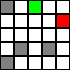

In [3]:
img_rgb1

In [4]:
print(str(grid_world1))

# . G . . 
. . . . S 
. . . . . 
. # . # . 
# . . . . 



In [5]:
print(f"{grid_world1.a_star() = }")

grid_world1.a_star() = ('go up', 'go left', 'go left')


## 3 Open Flamingo Inference
Source: https://github.com/mlfoundations/open_flamingo

## 3.1  Reference

In [7]:
from open_flamingo import create_model_and_transforms
model, image_processor, tokenizer = create_model_and_transforms(
    clip_vision_encoder_path="ViT-L-14",
    clip_vision_encoder_pretrained="openai",
    lang_encoder_path="togethercomputer/RedPajama-INCITE-Instruct-3B-v1",
    tokenizer_path="togethercomputer/RedPajama-INCITE-Instruct-3B-v1",
    cross_attn_every_n_layers=2
)

# grab model checkpoint from huggingface hub
from huggingface_hub import hf_hub_download
import torch

checkpoint_path = hf_hub_download("openflamingo/OpenFlamingo-4B-vitl-rpj3b-langinstruct", "checkpoint.pt")
model.load_state_dict(torch.load(checkpoint_path), strict=False)


Using pad_token, but it is not set yet.


Flamingo model initialized with 1089480736 trainable parameters


_IncompatibleKeys(missing_keys=['vision_encoder.class_embedding', 'vision_encoder.positional_embedding', 'vision_encoder.proj', 'vision_encoder.conv1.weight', 'vision_encoder.ln_pre.weight', 'vision_encoder.ln_pre.bias', 'vision_encoder.transformer.resblocks.0.ln_1.weight', 'vision_encoder.transformer.resblocks.0.ln_1.bias', 'vision_encoder.transformer.resblocks.0.attn.in_proj_weight', 'vision_encoder.transformer.resblocks.0.attn.in_proj_bias', 'vision_encoder.transformer.resblocks.0.attn.out_proj.weight', 'vision_encoder.transformer.resblocks.0.attn.out_proj.bias', 'vision_encoder.transformer.resblocks.0.ln_2.weight', 'vision_encoder.transformer.resblocks.0.ln_2.bias', 'vision_encoder.transformer.resblocks.0.mlp.c_fc.weight', 'vision_encoder.transformer.resblocks.0.mlp.c_fc.bias', 'vision_encoder.transformer.resblocks.0.mlp.c_proj.weight', 'vision_encoder.transformer.resblocks.0.mlp.c_proj.bias', 'vision_encoder.transformer.resblocks.1.ln_1.weight', 'vision_encoder.transformer.resbloc

In [8]:
# grab model checkpoint from huggingface hub
from huggingface_hub import hf_hub_download
import torch
from PIL import Image
import requests
device = "cpu"
# if torch.cuda.is_available():
#     print("CUDA is available! Using GPU for calculations.")
#     device = torch.device("cuda")
# else:
#     print("CUDA is not available. Using CPU for calculations.")
#     device = torch.device("cpu")
model = model.to(device)

In [9]:
from PIL import Image
import requests
import torch

"""
Step 1: Load images
"""
demo_image_one = Image.open(
    requests.get(
        "http://images.cocodataset.org/val2017/000000039769.jpg", stream=True
    ).raw
)

demo_image_two = Image.open(
    requests.get(
        "http://images.cocodataset.org/test-stuff2017/000000028137.jpg",
        stream=True
    ).raw
)

query_image = Image.open(
    requests.get(
        "http://images.cocodataset.org/test-stuff2017/000000028352.jpg", 
        stream=True
    ).raw
)


"""
Step 2: Preprocessing images
Details: For OpenFlamingo, we expect the image to be a torch tensor of shape 
 batch_size x num_media x num_frames x channels x height x width. 
 In this case batch_size = 1, num_media = 3, num_frames = 1,
 channels = 3, height = 224, width = 224.
"""
vision_x = [image_processor(demo_image_one).unsqueeze(0), image_processor(demo_image_two).unsqueeze(0), image_processor(query_image).unsqueeze(0)]
vision_x = torch.cat(vision_x, dim=0)
vision_x = vision_x.unsqueeze(1).unsqueeze(0).to(device)

"""
Step 3: Preprocessing text
Details: In the text we expect an <image> special token to indicate where an image is.
 We also expect an <|endofchunk|> special token to indicate the end of the text 
 portion associated with an image.
"""
tokenizer.padding_side = "left" # For generation padding tokens should be on the left
lang_x = tokenizer(
    ["<image>An image of two cats.<|endofchunk|><image>An image of a bathroom sink.<|endofchunk|><image>An image of"],
    return_tensors="pt",
)


"""
Step 4: Generate text
"""
generated_text = model.generate(
    vision_x=vision_x,
    lang_x=lang_x["input_ids"],
    attention_mask=lang_x["attention_mask"],
    max_new_tokens=20,
    num_beams=3,
)

print("Generated text: ", tokenizer.decode(generated_text[0]))

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image>An image of two cats.<|endofchunk|><image>An image of a bathroom sink.<|endofchunk|><image>An image of a buffet table.<|endofchunk|>


## 3.2 Few Shot Learning - only rgb input

In [10]:
from PIL import Image
import requests
import torch
import numpy as np
"""
Step 1: Load images
"""
dataset = GridDataset(grid_size=5, seed = 42, wall_symbol="#", free_symbol=".", cell_size=5)
img_rgb1, gridworld1 = dataset[0]
img_rgb2, gridworld2 = dataset[1]
img_rgb3, gridworld3 = dataset[2]
img_rgb4, gridworld4 = dataset[3]
ascii_inp1, path1 = str(gridworld1), gridworld1.a_star()
ascii_inp2, path2 = str(gridworld2), gridworld2.a_star()
ascii_inp3, path3 = str(gridworld3), gridworld3.a_star()
ascii_inp4, path4 = str(gridworld4), gridworld4.a_star()

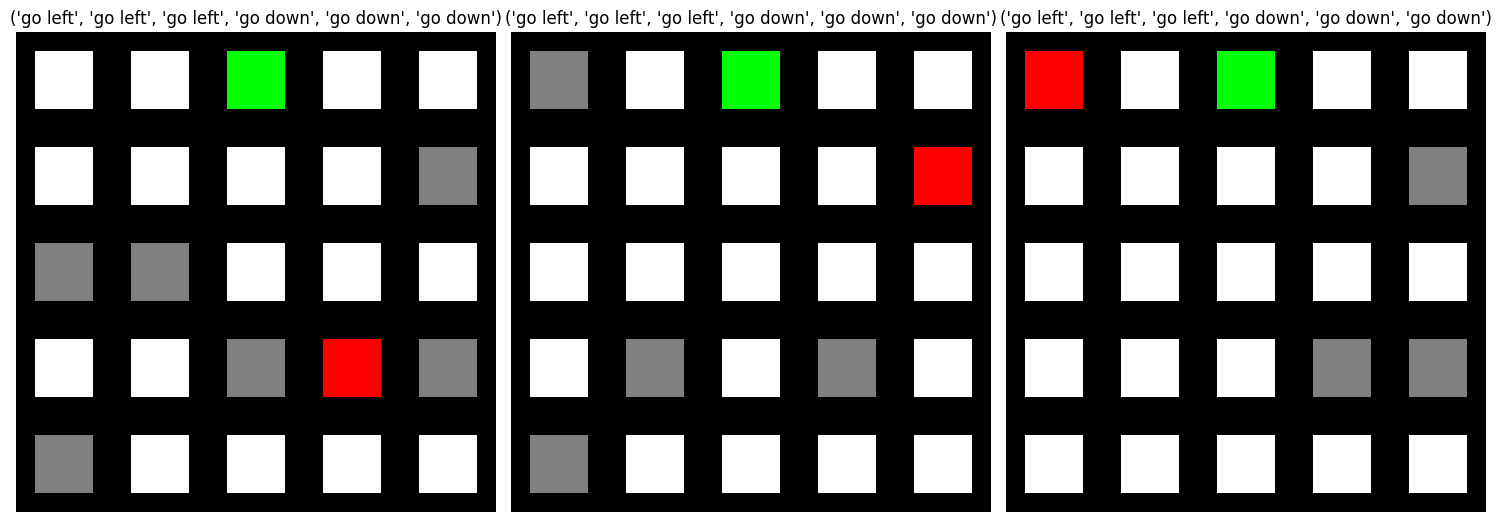

In [11]:
from src_code.data_utils.dataset_utils import draw_image_grid
draw_image_grid([(img_rgb1, path1), (img_rgb2, path2), (img_rgb3, path3)])

In [13]:
from src_code.data_utils.prompt_utils import prompt_generator
print(prompt_generator(grid_world1, img=img_rgb1, img_symbol="<image>"))

<image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?



## OpenFlamingo RGB Prompt

In [14]:
from src_code.data_utils.prompt_utils import generate_inputs_for_openflamingo_rgb_and_text
dataset = GridDataset(grid_size=5, seed = 42, wall_symbol="#", free_symbol=".")
query_idx=1
vision_x, lang_x, str_prompt = generate_inputs_for_openflamingo_rgb_and_text(tokenizer, image_processor, dataset, query_idx=query_idx, img_symbol="<image>")
print(str_prompt)

<image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goal cell?



In [15]:
vision_x[0][0].shape

torch.Size([1, 3, 224, 224])

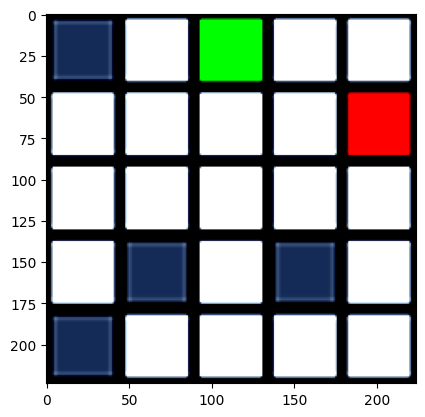

In [16]:
import matplotlib.pyplot as plt
plt.imshow(vision_x[0][1][0].permute(1, 2, 0))

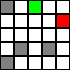

In [17]:
dataset[1][0]

### 3.2.1 One Shot Learning RGB and Text

In [ ]:
for query_idx in range(100):

    vision_x, lang_x, str_prompt = generate_inputs_for_openflamingo_rgb_and_text(tokenizer, image_processor, dataset, img_symbol="<image>", query_idx=query_idx)
    
    """
    Step 4: Generate text
    """
    generated_text = model.generate(
        vision_x=vision_x,
        lang_x=lang_x["input_ids"],
        attention_mask=lang_x["attention_mask"],
        max_new_tokens=20,
        num_beams=3,
    )
    
    print("Generated text: ", tokenizer.decode(generated_text[0]))

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image> In this example, the path from the red starting cell to the green goal cell is ('go up', 'go up', 'go up', 'go left')<|endofchunk|><image> is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Can you find the path from the starting cell to the goa

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


### 3.2.2 only Text

#### OpenFlamingo Only Text Prompt

In [22]:

from src_code.data_utils.prompt_utils import generate_inputs_for_openflamingo_text
dummy_vision_x, lang_x, str_prompt = generate_inputs_for_openflamingo_text(tokenizer, image_processor, dataset, query_idx=1, pure_language=True)
print(str_prompt)


Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 4).
The goal cell is at (0, 2).
There are some obstacles at [(0, 0), (3, 1), (3, 3), (4, 0)].

Output example:
('go up', 'go right'

In [23]:
for query_idx in range(100):
    dummy_vision_x, lang_x, str_prompt = generate_inputs_for_openflamingo_text(tokenizer, image_processor, dataset, query_idx=query_idx, pure_language=True)
    """
    Step 4: Generate text
    """
    generated_text = model.generate(
        vision_x=dummy_vision_x,
        lang_x=lang_x["input_ids"],
        attention_mask=lang_x["attention_mask"],
        max_new_tokens=20,
        num_beams=3,
    )
    
    print("Generated text: ", tokenizer.decode(generated_text[0]))

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 3).
The goal cell is at (0, 2).
There are some obstacles at [(1, 4), (2, 0), (2, 1), (3, 2), (3, 4), (4, 0)].

Out

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 4).
The goal cell is at (0, 2).
There are some obstacles at [(0, 0), (3, 1), (3, 3), (4, 0)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 0).
The goal cell is at (0, 2).
There are some obstacles at [(1, 4), (3, 3), (3, 4)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 4).
The goal cell is at (4, 1).
There are some obstacles at [(0, 3), (0, 4), (2, 4), (4, 0)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 2).
The goal cell is at (0, 3).
There are some obstacles at [(0, 1), (0, 2), (1, 3), (3, 0), (3, 4)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 2).
The goal cell is at (2, 4).
There are some obstacles at [(0, 0), (1, 0), (2, 0), (3, 1), (3, 3), (4, 0), (4, 1

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 0).
The goal cell is at (3, 2).
There are some obstacles at [(0, 0), (0, 1), (1, 1), (1, 3), (2, 2), (3, 4)].

Out

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 1).
The goal cell is at (3, 0).
There are some obstacles at [(0, 0), (0, 3), (1, 0), (1, 2), (1, 3), (2, 2), (4, 0

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 2).
The goal cell is at (3, 1).
There are some obstacles at [(0, 0), (0, 1), (0, 2), (1, 1), (4, 2)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 4).
The goal cell is at (2, 2).
There are some obstacles at [(0, 0), (0, 2), (1, 0), (1, 3), (2, 4), (3, 1), (4, 4

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 0).
The goal cell is at (3, 3).
There are some obstacles at [(1, 0), (2, 1), (4, 2)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 4).
The goal cell is at (3, 3).
There are some obstacles at [(0, 2), (1, 1), (1, 3), (2, 1), (3, 1), (3, 2), (4, 1

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 2).
The goal cell is at (4, 2).
There are some obstacles at [(0, 0), (0, 1), (1, 4), (2, 1), (2, 3), (3, 0), (4, 1

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 2).
The goal cell is at (1, 1).
There are some obstacles at [(0, 3), (0, 4), (1, 3), (1, 4), (3, 0), (4, 1)].

Out

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 4).
The goal cell is at (4, 1).
There are some obstacles at [(1, 4), (3, 1), (3, 4), (4, 2), (4, 4)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 0).
The goal cell is at (4, 0).
There are some obstacles at [(0, 0), (0, 2), (4, 4)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 3).
The goal cell is at (3, 2).
There are some obstacles at [(1, 1), (1, 4), (4, 0)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 3).
The goal cell is at (2, 2).
There are some obstacles at [(0, 4), (1, 0), (3, 1), (3, 4)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 0).
The goal cell is at (3, 2).
There are some obstacles at [(0, 3), (1, 2), (1, 4), (2, 2), (3, 0)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 4).
The goal cell is at (1, 3).
There are some obstacles at [(1, 0), (2, 2), (3, 1), (3, 4), (4, 0), (4, 1)].

Out

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 2).
The goal cell is at (0, 2).
There are some obstacles at [(0, 1), (1, 0), (3, 3), (4, 0), (4, 1), (4, 2)].

Out

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 3).
The goal cell is at (3, 2).
There are some obstacles at [(1, 2), (2, 1), (3, 0), (4, 1), (4, 4)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 1).
The goal cell is at (0, 4).
There are some obstacles at [(0, 1), (0, 2), (3, 1), (4, 0)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 0).
The goal cell is at (0, 4).
There are some obstacles at [(1, 1), (1, 4), (2, 3), (3, 3), (4, 0)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 4).
The goal cell is at (1, 1).
There are some obstacles at [(0, 1), (0, 3), (1, 0), (2, 3), (4, 1), (4, 4)].

Out

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 0).
The goal cell is at (1, 2).
There are some obstacles at [(0, 1), (1, 3), (3, 1), (3, 4), (4, 2)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 1).
The goal cell is at (3, 4).
There are some obstacles at [(0, 1), (1, 2), (3, 2)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 2).
The goal cell is at (2, 1).
There are some obstacles at [(0, 0), (3, 1), (4, 3)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 1).
The goal cell is at (4, 4).
There are some obstacles at [(1, 1), (1, 2), (2, 2), (3, 2)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 0).
The goal cell is at (2, 4).
There are some obstacles at [(1, 1), (3, 2), (4, 3)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 2).
The goal cell is at (4, 0).
There are some obstacles at [(0, 3), (1, 0), (1, 1), (1, 2), (2, 0)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 3).
The goal cell is at (1, 0).
There are some obstacles at [(0, 0), (0, 1), (1, 1), (1, 4), (2, 4), (3, 0), (3, 3

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 1).
The goal cell is at (1, 2).
There are some obstacles at [(0, 3), (0, 4), (1, 3), (4, 3)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 1).
The goal cell is at (1, 2).
There are some obstacles at [(2, 3)].

Output example:
('go up', 'go right', 'go r

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 2).
The goal cell is at (4, 0).
There are some obstacles at [(1, 2), (1, 4), (2, 4), (3, 0)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 2).
The goal cell is at (1, 2).
There are some obstacles at [(3, 0), (3, 3), (4, 0), (4, 4)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 0).
The goal cell is at (0, 2).
There are some obstacles at [(0, 1), (3, 2), (4, 1)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 0).
The goal cell is at (4, 4).
There are some obstacles at [(0, 0), (2, 0), (2, 3)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 3).
The goal cell is at (0, 0).
There are some obstacles at [(0, 3), (2, 4)].

Output example:
('go up', 'go right

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 2).
The goal cell is at (3, 0).
There are some obstacles at [(0, 0), (1, 1), (2, 1), (2, 2), (4, 4)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 4).
The goal cell is at (4, 0).
There are some obstacles at [(2, 0), (2, 4)].

Output example:
('go up', 'go right

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 2).
The goal cell is at (1, 1).
There are some obstacles at [(1, 3), (2, 1), (4, 0)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 0).
The goal cell is at (2, 1).
There are some obstacles at [(1, 0), (1, 2), (2, 0), (2, 2), (3, 3), (4, 2)].

Out

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 2).
The goal cell is at (1, 3).
There are some obstacles at [(0, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (4, 0

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 4).
The goal cell is at (4, 0).
There are some obstacles at [(0, 0), (0, 2), (0, 3), (0, 4), (1, 0), (2, 3), (3, 1

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 3).
The goal cell is at (3, 2).
There are some obstacles at [(0, 0), (0, 2), (0, 3), (1, 0), (1, 3), (2, 0), (3, 3

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 3).
The goal cell is at (0, 4).
There are some obstacles at [(1, 0), (1, 3), (2, 1), (2, 2)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 0).
The goal cell is at (3, 4).
There are some obstacles at [(0, 4), (1, 1), (1, 2), (4, 1)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 2).
The goal cell is at (1, 4).
There are some obstacles at [(0, 3), (1, 0), (1, 3), (2, 4), (3, 1), (3, 2), (3, 4

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 2).
The goal cell is at (3, 0).
There are some obstacles at [(1, 3), (2, 4), (3, 2), (4, 4)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 2).
The goal cell is at (2, 1).
There are some obstacles at [(1, 3), (2, 2), (3, 3), (4, 0)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 4).
The goal cell is at (4, 1).
There are some obstacles at [(3, 0), (3, 1), (3, 3)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 0).
The goal cell is at (4, 3).
There are some obstacles at [(0, 2), (0, 3), (1, 4), (2, 4), (3, 4), (4, 0), (4, 4

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 1).
The goal cell is at (3, 4).
There are some obstacles at [(1, 1), (1, 2), (2, 2), (3, 1), (4, 4)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 3).
The goal cell is at (4, 2).
There are some obstacles at [(2, 0), (3, 3)].

Output example:
('go up', 'go right

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 1).
The goal cell is at (1, 2).
There are some obstacles at [(3, 2), (4, 2)].

Output example:
('go up', 'go right

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 0).
The goal cell is at (3, 4).
There are some obstacles at [(0, 4), (1, 4), (2, 1), (2, 3), (3, 3), (4, 1), (4, 3

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 2).
The goal cell is at (4, 4).
There are some obstacles at [(0, 0), (1, 3), (4, 1), (4, 3)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 1).
The goal cell is at (1, 1).
There are some obstacles at [(0, 0), (2, 0), (2, 3), (3, 2), (3, 4), (4, 0)].

Out

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 0).
The goal cell is at (3, 0).
There are some obstacles at [(0, 0), (0, 2), (2, 0), (2, 3), (3, 2), (3, 4), (4, 1

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 2).
The goal cell is at (4, 1).
There are some obstacles at [(1, 3), (2, 3), (3, 0), (4, 4)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 1).
The goal cell is at (4, 1).
There are some obstacles at [(1, 3), (3, 0)].

Output example:
('go up', 'go right

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 1).
The goal cell is at (0, 1).
There are some obstacles at [(0, 4), (1, 0), (1, 1), (2, 0), (2, 2), (4, 0)].

Out

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 3).
The goal cell is at (2, 2).
There are some obstacles at [(0, 1), (0, 3), (1, 0)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 0).
The goal cell is at (4, 3).
There are some obstacles at [(2, 0), (2, 2), (2, 3), (3, 3), (4, 4)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 2).
The goal cell is at (2, 4).
There are some obstacles at [(1, 2), (2, 2), (2, 3), (4, 0)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 2).
The goal cell is at (3, 1).
There are some obstacles at [(1, 0), (1, 3), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 0).
The goal cell is at (3, 3).
There are some obstacles at [(1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (3, 1), (4, 1

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 4).
The goal cell is at (0, 4).
There are some obstacles at [(2, 1), (2, 3), (3, 0), (3, 2), (3, 3)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 0).
The goal cell is at (1, 0).
There are some obstacles at [(3, 2), (3, 3)].

Output example:
('go up', 'go right

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 2).
The goal cell is at (3, 3).
There are some obstacles at [(0, 0), (0, 3), (2, 0), (3, 0), (3, 1), (4, 0), (4, 3

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 4).
The goal cell is at (4, 0).
There are some obstacles at [(0, 1), (0, 3), (0, 4), (2, 2), (3, 0), (4, 4)].

Out

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 4).
The goal cell is at (1, 2).
There are some obstacles at [(1, 1), (2, 1), (2, 2), (3, 0), (3, 1)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 0).
The goal cell is at (4, 3).
There are some obstacles at [(1, 1), (1, 4)].

Output example:
('go up', 'go right

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 4).
The goal cell is at (0, 2).
There are some obstacles at [(0, 0), (2, 2), (2, 4), (4, 2)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 4).
The goal cell is at (3, 3).
There are some obstacles at [(0, 0), (2, 1), (4, 0)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 3).
The goal cell is at (3, 1).
There are some obstacles at [(0, 1), (2, 1), (4, 0), (4, 3)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 2).
The goal cell is at (1, 1).
There are some obstacles at [(0, 0), (1, 4), (3, 0), (3, 4), (4, 4)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 0).
The goal cell is at (2, 2).
There are some obstacles at [(2, 0), (3, 3), (4, 2), (4, 4)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 3).
The goal cell is at (2, 4).
There are some obstacles at [(0, 0), (0, 3), (3, 3), (4, 3), (4, 4)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 3).
The goal cell is at (4, 3).
There are some obstacles at [(1, 3), (2, 2), (3, 3), (4, 2), (4, 4)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 3).
The goal cell is at (2, 4).
There are some obstacles at [(0, 2), (0, 3), (1, 1), (3, 2), (4, 0)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 3).
The goal cell is at (4, 2).
There are some obstacles at [(0, 4), (1, 4), (2, 2), (2, 3), (3, 3), (3, 4)].

Out

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 3).
The goal cell is at (0, 1).
There are some obstacles at [(0, 2), (0, 4), (1, 2), (1, 3), (3, 1), (3, 4), (4, 3

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 0).
The goal cell is at (3, 0).
There are some obstacles at [(1, 2), (4, 0), (4, 1), (4, 4)].

Output example:
('g

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 4).
The goal cell is at (0, 2).
There are some obstacles at [(0, 1), (3, 1)].

Output example:
('go up', 'go right

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 4).
The goal cell is at (2, 0).
There are some obstacles at [(2, 2), (4, 1), (4, 3)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 1).
The goal cell is at (4, 0).
There are some obstacles at [(1, 0), (2, 3), (3, 1), (3, 3), (3, 4)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 1).
The goal cell is at (2, 1).
There are some obstacles at [(1, 0), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 3

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 4).
The goal cell is at (2, 1).
There are some obstacles at [(0, 1), (1, 4), (3, 0), (3, 3), (4, 3), (4, 4)].

Out

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 0).
The goal cell is at (3, 4).
There are some obstacles at [(1, 4), (2, 1), (3, 2), (4, 0), (4, 2)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (0, 4).
The goal cell is at (1, 1).
There are some obstacles at [(1, 3), (2, 4)].

Output example:
('go up', 'go right

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 4).
The goal cell is at (4, 4).
There are some obstacles at [(2, 2), (3, 1), (4, 0)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 4).
The goal cell is at (2, 0).
There are some obstacles at [(0, 0), (0, 1), (2, 1), (2, 2), (4, 4)].

Output exam

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 1).
The goal cell is at (0, 2).
There are some obstacles at [(4, 0)].

Output example:
('go up', 'go right', 'go r

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 4).
The goal cell is at (4, 1).
There are some obstacles at [(0, 1), (1, 1), (2, 0), (2, 4), (3, 2), (4, 2), (4, 3

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 2).
The goal cell is at (3, 1).
There are some obstacles at [(0, 0), (0, 2), (0, 4), (1, 1), (1, 4), (4, 4)].

Out

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (1, 3).
The goal cell is at (2, 0).
There are some obstacles at [(0, 2), (1, 1), (3, 1), (4, 0), (4, 2), (4, 3)].

Out

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (2, 4).
The goal cell is at (0, 2).
There are some obstacles at [(2, 2), (4, 2), (4, 4)].

Output example:
('go up', '

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  
Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1
not solvable: it is not possible to go the the goal cell from the start cell

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (3, 3).
The goal cell is at (1, 4).
There are some obstacles at [(0, 0), (3, 2)].

Output example:
('go up', 'go right

### 3.2.3  only ASCII Input

#### OpenFlamingo Only ASCII

In [24]:
from src_code.data_utils.prompt_utils import generate_inputs_for_openflamingo_text
dummy_vision_x, lang_x, str_prompt = generate_inputs_for_openflamingo_text(tokenizer, image_processor, dataset, query_idx=1, pure_language=False)
print(str_prompt)

Here is the grid world:
# . G . . 
. . . . S 
. . . . . 
. # . # . 
# . . . . 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the . cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?



In [25]:
from src_code.data_utils.prompt_utils import generate_inputs_for_openflamingo_text

"""
Step 4: Generate text
"""
for query_idx in range(100):
    dummy_vision_x, lang_x, str_prompt = generate_inputs_for_openflamingo_text(tokenizer, image_processor, dataset, query_idx=query_idx, pure_language=False)
    generated_text = model.generate(
        vision_x=dummy_vision_x,
        lang_x=lang_x["input_ids"],
        attention_mask=lang_x["attention_mask"],
        max_new_tokens=20,
        num_beams=3,
    )
    print("Generated text: \n", tokenizer.decode(generated_text[0]))

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.. G.. 
.... # 
# #... 
.. # S # 
#.... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#. G.. 
.... S 
..... 
. #. #. 
#.... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
S. G.. 
.... # 
..... 
... # # 
..... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
... # # 
.... S 
.... # 
..... 
# G... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. # # G. 
.. S #. 
..... 
#... # 
..... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#.... 
#.... 
#... G 
. #. #. 
# # S.. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
# #... 
. #. #. 
.. #.. 
.. G. # 
S.... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#.. #. 
#. # #. 
. S #.. 
G.... 
#.. # # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sho

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
# # #.. 
. # S.. 
..... 
. G... 
.. #.. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#. #.. 
#.. #. 
.. G. # 
. #.. S 
.... # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sho

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
#.... 
. #... 
... G. 
S. #.. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shortes

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.. #.. 
. #. #. 
. #... 
. # # G S 
. # #. # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
# #... 
.... # 
. #. #. 
#. S.. 
. # G #. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sh

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
... # # 
. G. # # 
.. S.. 
#.... 
. #... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sho

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.... S 
.... # 
..... 
. #.. # 
. G #. # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sho

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#. #.. 
S.... 
..... 
..... 
G... # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shortest

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
. #.. # 
... S. 
.. G.. 
#.... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.... # 
#.... 
.. G.. 
. #.. # 
... S. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
... #. 
S. #. # 
.. #.. 
#. G.. 
..... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.... S 
#.. G. 
.. #.. 
. #.. # 
# #... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. # G.. 
#. S.. 
..... 
... #. 
# # #.. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
.. # S. 
. #... 
#. G.. 
. #.. # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. # #. G 
. S... 
..... 
. #... 
#.... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.... G 
. #.. # 
S.. #. 
... #. 
#.... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. #. #. 
# G... 
... #. 
.... S 
. #.. # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sho

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. #... 
.. G #. 
..... 
S #.. # 
.. #.. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. #... 
. S #.. 
..... 
.. #. G 
..... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#.... 
..... 
. G... 
. # S.. 
... #. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. S... 
. # #.. 
.. #.. 
.. #.. 
.... G 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
. #... 
.... G 
.. #.. 
S.. #. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
... #. 
# # #.. 
#.... 
..... 
G. S.. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
# #. S. 
G #.. # 
.... # 
#.. #. 
..... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. S. # # 
.. G #. 
..... 
..... 
... #. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
.. G.. 
... #. 
..... 
. S... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shortes

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
.. #. # 
.... # 
#.... 
G. S.. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
.. G.. 
..... 
#.. #. 
#. S. # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. # G.. 
..... 
S.... 
.. #.. 
. #... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#.... 
..... 
#.. #. 
..... 
S... G 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shortest

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
G.. #. 
..... 
.... # 
... S. 
..... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shortes

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#.... 
. # S.. 
. # #.. 
G.... 
.... # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
..... 
#... # 
.... S 
G.... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shortest

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
. G. #. 
. #... 
.. S.. 
#.... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
S.... 
#. #.. 
# G #.. 
... #. 
.. #.. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.. S #. 
... G. 
.... # 
# # # #. 
#... # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sh

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#. # # # 
#.... 
... #. 
. # # # S 
G. #.. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the s

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#. # #. 
#.. #. 
#.. S. 
.. G #. 
.. #.. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sho

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
... S G 
#.. #. 
. # #.. 
..... 
..... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.... # 
. # #.. 
S.... 
.... G 
. #... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
... #. 
#.. # G 
.... # 
. # #. # 
#. S.. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sh

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.. S.. 
... #. 
.... # 
G. #.. 
.... # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
... #. 
. G #.. 
.. S #. 
#.... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
.... S 
..... 
# #. #. 
. G... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.. # #. 
.... # 
S... # 
.... # 
#.. G # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sho

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
. # #.. 
.. #.. 
. #.. G 
. S.. # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sho

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
... S. 
#.... 
... #. 
.. G.. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shortes

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. S... 
.. G.. 
..... 
.. #.. 
.. #.. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.... # 
.... # 
. #. #. 
... # G 
S #. #. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sh

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#. S.. 
... #. 
..... 
..... 
. #. # G 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#.... 
. G... 
#.. #. 
.. #. # 
# S... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#. #.. 
S.... 
#.. #. 
G. #. # 
. # # #. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sho

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
... #. 
.. S #. 
#.... 
. G.. # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
... #. 
..... 
# S... 
. G... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shortes

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. G.. # 
# #... 
#. #.. 
..... 
# S... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. #. #. 
#.... 
.. G.. 
... S. 
..... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
..... 
#. # #. 
S.. #. 
... G # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
.. #.. 
.. # # G 
.. S.. 
#.... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.. S.. 
#.. #. 
..... 
. G. # # 
. # # #. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sh

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
S.... 
.. # # # 
. # #.. 
. #. G. 
. # #. # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the 

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.... G 
..... 
. #. #. 
#. # # S 
..... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
S.... 
G.... 
..... 
.. # #. 
..... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shortest

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#. S #. 
..... 
#.... 
# #. G. 
#.. #. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. #. # # 
..... 
.. #. S 
#.... 
G... # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.... S 
. # G.. 
. # #.. 
# #... 
..... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
. #.. # 
S.... 
..... 
... G. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shortes

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#. G.. 
..... 
.. #. # 
..... 
.. #. S 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#.... 
..... 
. #... 
... G S 
#.... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shortes

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. #... 
..... 
. #. S. 
. G... 
#.. #. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#.... 
. G.. # 
.. S.. 
#... # 
.... # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
S.... 
#. G.. 
... #. 
.. #. # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#.. #. 
... S. 
.... G 
... #. 
... # # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
... #. 
.. # S. 
... #. 
.. # G # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sho

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.. # #. 
. #... 
.... G 
.. #.. 
#.. S. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.... # 
... S # 
.. # #. 
... # # 
.. G.. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sh

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. G #. # 
.. # #. 
..... 
. #. S # 
... #. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the s

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
.. #.. 
S.... 
G.... 
# #.. # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shortes

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. # G.. 
.... S 
..... 
. #... 
..... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.... S 
..... 
G. #.. 
..... 
. #. #. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
# S... 
... #. 
. #. # # 
G.... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
#. # # # 
. G. # # 
. S. #. 
..... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sh

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. #.. S 
.... # 
. G... 
#.. #. 
... # # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sho

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
S... # 
. #... 
.. #. G 
#. #.. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.... S 
. G. #. 
.... # 
..... 
..... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
..... 
..... 
.. #.. 
. #.. S 
#... G 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shorte

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
# #... 
..... 
G # #.. 
.... S 
.... # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.. G.. 
..... 
..... 
..... 
# S... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shortest

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
. #... 
. #... 
#... # 
.. #.. 
. G # # S 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sh

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#. #. # 
. #.. # 
.. S.. 
. G... 
.... # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the sho

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.. #.. 
. #. S. 
G.... 
. #... 
#. # #. 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shor

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
.. G.. 
..... 
.. #. S 
..... 
.. #. # 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the short

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text: 
 Here is the grid world:
#.... 
.... G 
..... 
.. # S. 
..... 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the. cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?
Can you find the shortes

# What we tried.
1. directly prompt - garbage answer
2. one shot propmt - ???
3. two shot prompt - doesnt work
4. different image resolutions
5. ascii
6. bigger models??